## Face Swapping

In [1]:
# Import modules

import cv2
import dlib
import requests
import numpy as np

from PIL import Image

from utils import *


#### Getting Images

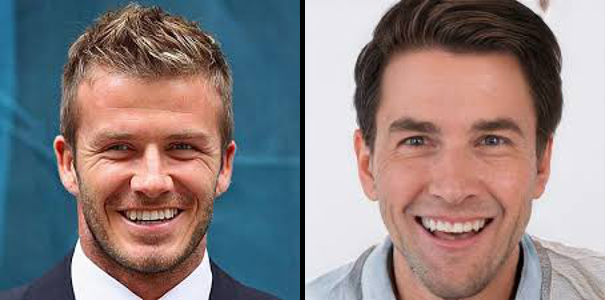

In [2]:
def get_image(url):
    img = Image.open(requests.get(url, stream=True).raw)
    img = img.resize((300, 300))
    return img


# Source Image
src_img = get_image('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSx8Pu1tW1uCiZPfj9K1EL6uHxbg3bOKO9XkA&usqp=CAU')
src_img.save('images/image_1.jpg')
src_img = np.array(src_img)

# Destination Image
dest_img = get_image('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTYX1dyl9INRo5cbvDeTILRcZVzfcMsCsE0kg&usqp=CAU')
dest_img.save('images/image_2.jpg')
dest_img = np.array(dest_img)

DisplayImages([src_img, dest_img])


#### Processing Images

Steps to Swap Faces

- Convert Images to Grayscale
- Find Feature Points of faces
- Divide the Face into Triangles using Delaunay Triangulation
- Generate new face by Affine transforming triangles in source image to triangles in destination image
- Replace Face in destination image with new face
- Apply Colour Correction to blend the new face in destination image

In [3]:
# Converting to GrayScale
src_gray_img = cv2.cvtColor(src_img, cv2.COLOR_RGB2GRAY)
dest_gray_img = cv2.cvtColor(dest_img, cv2.COLOR_RGB2GRAY)


In [4]:
# Calculating Feature points of Faces
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('dlib_data/shape_predictor_68_face_landmarks.dat')


def FindFeaturePoints(img):
    faces = detector(img)
    for face in faces:
        landmarks = predictor(img, face)
        points = []
        for n in range(0, 68):
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            points.append((x, y))

    return np.array(points, dtype=np.int32)


src_points = FindFeaturePoints(src_gray_img)
dest_points = FindFeaturePoints(dest_gray_img)


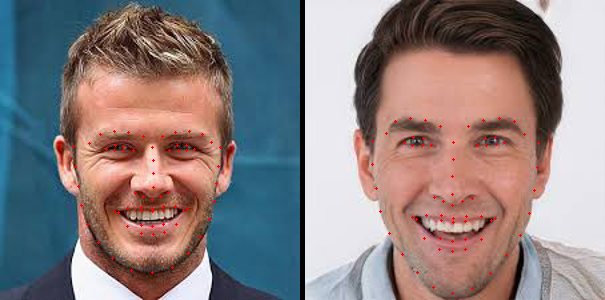

In [5]:
# Display Images with Feature Points
def DrawPoints(img, points):
    for point in points:
        cv2.circle(img, point, 0, (255, 0, 0), thickness=2)
    return img


src_features_img = DrawPoints(src_img.copy(), src_points)
dest_features_img = DrawPoints(dest_img.copy(), dest_points)

DisplayImages([src_features_img, dest_features_img])


In [6]:
# Calculating Delaunay Triangles of Faces
def FindDelaunayTriangles(points):
    convexhull = cv2.convexHull(points)
    bounding_rectangle = cv2.boundingRect(convexhull)

    triangles = cv2.Subdiv2D(bounding_rectangle)
    triangles.insert(points.tolist())
    triangles = triangles.getTriangleList()
    return np.array(triangles, dtype=np.int32)


src_triangles = FindDelaunayTriangles(src_points)
dest_triangles = FindDelaunayTriangles(dest_points)


Triangles in both the lists may not correspond to each other.

To address this we will convert points in triangle list of source image to their indices in feature point list and use these indices to generate new triangle lists.

We will also convert shape of triangle from (6,) to (3, 2)

In [7]:
# Making list of triangle indices
triangles_indices = []
for triangle in src_triangles:
    point_1 = np.array((triangle[0], triangle[1]))
    point_2 = np.array((triangle[2], triangle[3]))
    point_3 = np.array((triangle[4], triangle[5]))

    index_1 = np.argwhere((src_points == np.array(point_1)).all(axis=1))[0][0]
    index_2 = np.argwhere((src_points == np.array(point_2)).all(axis=1))[0][0]
    index_3 = np.argwhere((src_points == np.array(point_3)).all(axis=1))[0][0]

    triangles_indices.append([index_1, index_2, index_3])


In [8]:
# Making list of triangles of shape
def triangle_indices_to_list(triangle_indices, points):
    triangles = []
    for indices in triangle_indices:
        point_1 = points[indices[0]]
        point_2 = points[indices[1]]
        point_3 = points[indices[2]]

        triangles.append(np.array([point_1, point_2, point_3], dtype=np.int32))

    return np.array(triangles)


src_triangles = triangle_indices_to_list(triangles_indices, src_points)
dest_triangles = triangle_indices_to_list(triangles_indices, dest_points)


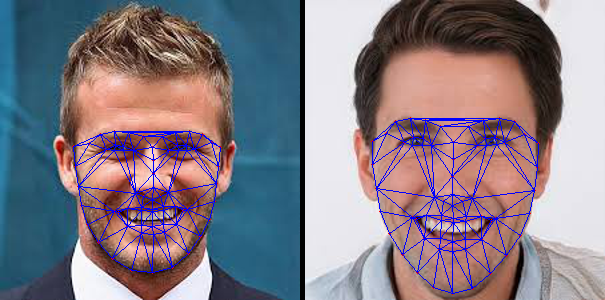

In [9]:
# Display Images with Delauny Triangles
def DrawTriangles(img, triangles):
    for triangle in triangles:
        cv2.line(img, triangle[0], triangle[1], (0, 0, 255))
        cv2.line(img, triangle[0], triangle[2], (0, 0, 255))
        cv2.line(img, triangle[1], triangle[2], (0, 0, 255))
    return img


src_triangles_img = DrawTriangles(src_features_img.copy(), src_triangles)
dest_triangles_img = DrawTriangles(dest_features_img.copy(), dest_triangles)

DisplayImages([src_triangles_img, dest_triangles_img])


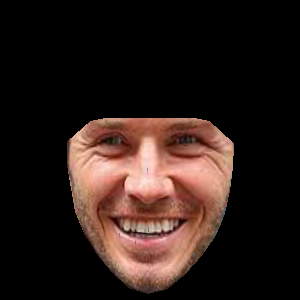

In [10]:
# Generate New Face
new_face_img = np.zeros_like(dest_img)


def RelativeTriangle(triangle):
    point_1 = triangle[0]
    point_2 = triangle[1]
    point_3 = triangle[2]

    x, y, _, _ = cv2.boundingRect(triangle)

    points = np.array([[point_1[0] - x, point_1[1] - y],
                       [point_2[0] - x, point_2[1] - y],
                       [point_3[0] - x, point_3[1] - y]])

    return points


for src_triangle, dest_triangle in zip(src_triangles, dest_triangles):
    rel_src_triangle = RelativeTriangle(src_triangle)
    rel_dest_triangle = RelativeTriangle(dest_triangle)

    # Get Triangle from source image
    x, y, w, h = cv2.boundingRect(src_triangle)
    cropped_src_triangle = src_img[y: y + h, x: x + w]

    # Make mask for destination image
    x, y, w, h = cv2.boundingRect(dest_triangle)
    cropped_dest_mask = np.zeros((h, w), dtype=np.uint8)
    cv2.fillConvexPoly(cropped_dest_mask, rel_dest_triangle, 255)
    cv2.line(cropped_dest_mask, rel_dest_triangle[0], rel_dest_triangle[1], 255, 1)
    cv2.line(cropped_dest_mask, rel_dest_triangle[0], rel_dest_triangle[2], 255, 1)
    cv2.line(cropped_dest_mask, rel_dest_triangle[1], rel_dest_triangle[2], 255, 1)

    # Affine Transform cropped source triangle to destination triangle
    M = cv2.getAffineTransform(np.float32(rel_src_triangle), np.float32(rel_dest_triangle))
    warped_triangle = cv2.warpAffine(cropped_src_triangle, M, (w, h))
    warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=cropped_dest_mask)

    # Construct destination face
    cropped_new_face = new_face_img[y: y + h, x: x + w]
    cropped_new_face_gray = cv2.cvtColor(cropped_new_face, cv2.COLOR_RGB2GRAY)
    _, opposite_mask = cv2.threshold(cropped_new_face_gray, 1, 255, cv2.THRESH_BINARY_INV)  # To take care of triangle borders

    warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=opposite_mask)

    cropped_new_face = cv2.add(cropped_new_face, warped_triangle)
    new_face_img[y: y + h, x: x + w] = cropped_new_face

Image.fromarray(new_face_img)


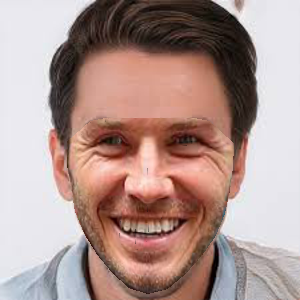

In [11]:
# Swap New face with face in destination image
dest_convexhull = cv2.convexHull(dest_points)
dest_face_mask = np.zeros_like(dest_gray_img, dtype=np.uint8)
dest_face_mask = cv2.fillConvexPoly(dest_face_mask, dest_convexhull, 255)
dest_opposite_face_mask = cv2.bitwise_not(dest_face_mask)

swap_img = cv2.bitwise_and(dest_img, dest_img, mask=dest_opposite_face_mask)
swap_img = cv2.add(swap_img, new_face_img)

Image.fromarray(swap_img)


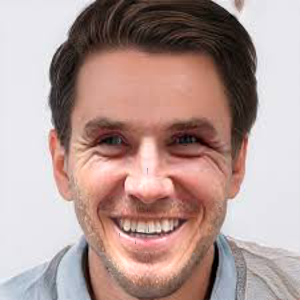

In [12]:
# Correct colours with seamlessclone
(x, y, w, h) = cv2.boundingRect(dest_convexhull)
center = ((x + x + w) // 2, (y + y + h) // 2)
swap_img = cv2.seamlessClone(swap_img, dest_img, dest_face_mask, center, cv2.NORMAL_CLONE)

Image.fromarray(swap_img)


## Results

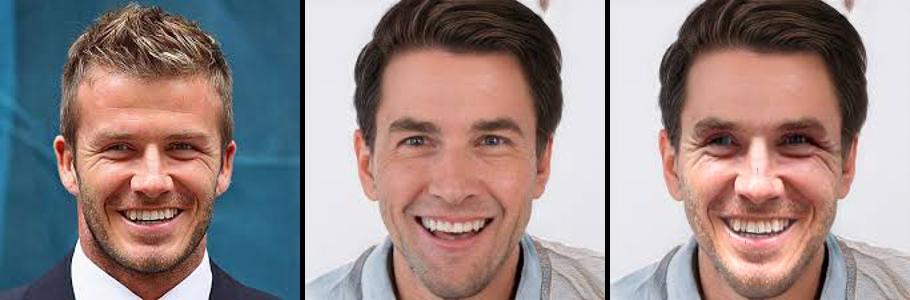

In [13]:
DisplayImages([src_img, dest_img, swap_img])
